Author: Rohan Sambidi  
Course: CSE 569- Fundamentals-of-Statistical-Learning-and-Pattern-Recognition  
Project: Feature Extraction, Density Estimation and Bayesian Classification  
Semester: Fall 2022

In [1]:
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from scipy.io import loadmat
train_data = loadmat('/Users/rohansambidi/Downloads/train_data.mat')
test_data = loadmat('/Users/rohansambidi/Downloads/test_data.mat')

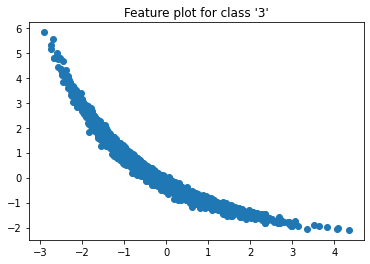

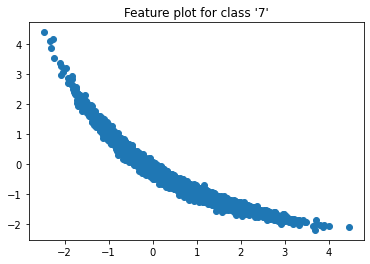

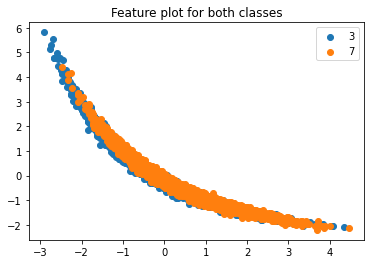

In [2]:
# Task:1

def get_FeatureVector(data, threshold):
    T = threshold   #Threshold for evaluating r_i
    data_size = len(data['data'])  # Number of samples in the data set. For training set: "3": 5713 "7": 5835

    k = np.empty([data_size])
    r = np.empty([data_size])

    X = np.empty([data_size, 2])

    for i in range(data_size):
        lin_data = data['data'][i].reshape(-1)
        k[i] = skew(lin_data)    # For every image sample, calculate the skewness

        bright_pxls = len(np.where(lin_data > T)[0])
        r[i] = bright_pxls/(784 - bright_pxls)   # Calculate the ratio of brighter pixels to darker pixels using T

        X[i] = k[i], r[i]   # 2-d feature vector for each sample

    M_k, S_k = np.mean(k), np.std(k)
    M_r, S_r = np.mean(r), np.std(r)

    Y = np.empty([data_size, 2])

    for i in range(data_size):
        Y[i] = [(k[i]-M_k)/S_k, (r[i]-M_r)/S_r]   # Normalize the feature vector

    return Y


Y = get_FeatureVector(train_data, 150) # Feature vectors for the training data


# Plotting the features for visualization
plt.scatter(Y[:5713,0], Y[:5713,1])
plt.title("Feature plot for class '3'")
plt.show()

plt.scatter(Y[5713:,0], Y[5713:,1])
plt.title("Feature plot for class '7'")
plt.show()

plt.scatter(Y[:5713,0], Y[:5713,1], label='3')
plt.scatter(Y[5713:,0], Y[5713:,1], label='7')
plt.title("Feature plot for both classes")
plt.legend()
plt.show()

In [3]:
Y # Feature vector for train_data with threshold=150

array([[-0.31262964, -0.05124354],
       [ 0.96546012, -0.84799866],
       [ 0.51651703, -0.81586994],
       ...,
       [ 0.75421946, -0.94384786],
       [ 0.23280633, -0.32290778],
       [-0.26834176,  0.12176421]])

In [4]:
# Task:2

# Since the distribution is assumed to be Gaussian,
# the mean and variance are estimated as follows: 

def get_Estimates(feature_vector):
    count = 5713
        
    mean_est_3 = np.mean(feature_vector[:count], axis=0) # MU estimate for class '3'

    mean_est_7 = np.mean(feature_vector[count:], axis=0) # Mu estimate for class '7'

    var_est_3 = np.array([[0,0],[0,0]]) # Sigma estimate for class '3' (2x2 matrix)
    for i in feature_vector[:count]:
        i.shape = (2,1)
        var_est_3 = np.add(var_est_3, i.dot(i.transpose()))
    var_est_3 /= count-1

    var_est_7 = np.array([[0,0],[0,0]]) # Sigma estimate for class '7' (2x2 matrix)
    for i in feature_vector[count:]:
        i.shape = (2,1)
        var_est_7 = np.add(var_est_7, i.dot(i.transpose()))
    var_est_7 /= (len(feature_vector)-(count-1))
    
    return [mean_est_3, mean_est_7, var_est_3, var_est_7]

In [5]:
train_estimates = get_Estimates(Y)

mean_est_3, mean_est_7, var_est_3, var_est_7 = train_estimates

In [20]:
print("Estimates:\n")
print("Mu for class '3':\n\n", mean_est_3)
print("\nMu for class '7':\n\n", mean_est_7)
print("\nSigma for class '3':\n\n", var_est_3)
print("\nSigma for class '7':\n\n", var_est_7)

Estimates:

Mu for class '3':

 [-0.37951983  0.30674367]

Mu for class '7':

 [ 0.37158471 -0.30033017]

Sigma for class '3':

 [[ 0.98781702 -1.032681  ]
 [-1.032681    1.23078715]]

Sigma for class '7':

 [[ 1.01192413 -0.84119364]
 [-0.84119364  0.77411649]]


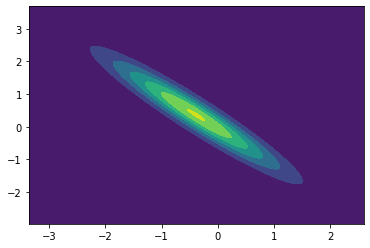

In [6]:
# plotting the 2d Gaussian distribution for class '3' in training data

std = [np.sqrt(var_est_3[0, 0]), np.sqrt(var_est_3[1, 1])]

x = np.linspace(mean_est_3[0] - 3 * std[0], mean_est_3[0] + 3 * std[0], 1000)
y = np.linspace(mean_est_3[1] - 3 * std[1], mean_est_3[1] + 3 * std[1], 1000)

x, y = np.meshgrid(x, y)
xy = np.vstack((x.flatten(), y.flatten())).T

normal_3 = multivariate_normal(mean_est_3, var_est_3)
z = normal_3.pdf(xy)
z = z.reshape(1000, 1000, order='F')

plt.contourf(x, y, z.T)
plt.show()

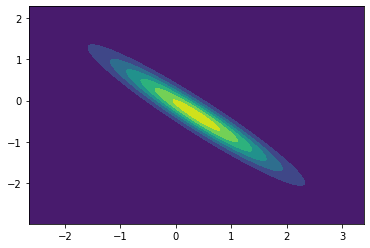

In [7]:
# plotting the 2d Gaussian distribution for class '7' in training data

std = [np.sqrt(var_est_7[0, 0]), np.sqrt(var_est_7[1, 1])]

x = np.linspace(mean_est_7[0] - 3 * std[0], mean_est_7[0] + 3 * std[0], 1000)
y = np.linspace(mean_est_7[1] - 3 * std[1], mean_est_7[1] + 3 * std[1], 1000)

x, y = np.meshgrid(x, y)
xy = np.vstack((x.flatten(), y.flatten())).T

normal_3 = multivariate_normal(mean_est_7, var_est_7)
z = normal_3.pdf(xy)
z = z.reshape(1000, 1000, order='F')

plt.contourf(x, y, z.T)
plt.show()

In [8]:
# Task:3

def Classification(data, feature_vector, estimates, prob_3, prob_7):
    mean_est_3, mean_est_7, var_est_3, var_est_7 = estimates
    data_size = len(data['label'][0])
    classes = []
    
    for i in range (data_size):
        g1 = -0.5 * (np.dot(np.dot(feature_vector[i]-mean_est_3, np.linalg.inv(var_est_3)), 
                            (feature_vector[i]-mean_est_3).T)-np.log(2*np.pi)-(0.5*np.log(np.linalg.det(var_est_3)))+prob_3)
        g2 = -0.5 * (np.dot(np.dot(feature_vector[i]-mean_est_7, np.linalg.inv(var_est_7)), 
                            (feature_vector[i]-mean_est_7).T)-np.log(2*np.pi)-(0.5*np.log(np.linalg.det(var_est_7)))+prob_7)

        temp = []

        if g1>g2:
            classes.append(3)
        else:
            classes.append(7)
            
    return 1-sum(data['label'][0] == classes)/len(classes)

In [ ]:
# Task:4

# Case-1

In [9]:
print("Case-1: Threshold (T) = 150")
print("P(3) = P(7) = 0.5")

Y_train = get_FeatureVector(train_data, 150)

train_estimates = get_Estimates(Y_train)
mean_est_3, mean_est_7, var_est_3, var_est_7 = train_estimates

error = Classification(train_data, Y_train, train_estimates, 0.5, 0.5)
print(f"Error rate for train_data: {error*100}")

Case-1: Threshold (T) = 150
P(3) = P(7) = 0.5
Error rate for train_data: 35.270176653966054


In [10]:
print("Case-1: Threshold (T) = 150")
print("P(3) = P(7) = 0.5")

Y_test = get_FeatureVector(test_data, 150)

error = Classification(test_data, Y_test, train_estimates, 0.5, 0.5)
print(f"Error rate for test_data: {error*100}")

Case-1: Threshold (T) = 150
P(3) = P(7) = 0.5
Error rate for test_data: 37.525987525987524


In [11]:
print("Case-1: Threshold (T) = 150")
print("P(3) = 0.3, P(7) = 0.7")

error = Classification(train_data, Y, train_estimates, 0.3, 0.7)
print(f"Error rate for train_data: {error*100}")

Case-1: Threshold (T) = 150
P(3) = 0.3, P(7) = 0.7
Error rate for train_data: 37.38309664011085


In [12]:
print("Case-1: Threshold (T) = 150")
print("P(3) = 0.3, P(7) = 0.7")

error = Classification(test_data, Y_test, train_estimates, 0.3, 0.7)
print(f"Error rate for test_data: {error*100}")

Case-1: Threshold (T) = 150
P(3) = 0.3, P(7) = 0.7
Error rate for test_data: 39.5010395010395


In [ ]:
# Task:4

# Case-2

In [26]:
print("Case-2: Threshold (T) = 200")
print("P(3) = P(7) = 0.5")

Y_train = get_FeatureVector(train_data, 200)

train_estimates = get_Estimates(Y_train)
mean_est_3, mean_est_7, var_est_3, var_est_7 = train_estimates

error = Classification(train_data, Y_train, train_estimates, 0.5, 0.5)
print(f"Error rate for train_data: {error*100}")

Case-2: Threshold (T) = 200
P(3) = P(7) = 0.5
Error rate for train_data: 34.18773813647385


In [14]:
print("Case-2: Threshold (T) = 200")
print("P(3) = P(7) = 0.5")

Y_test = get_FeatureVector(test_data, 200)

error = Classification(test_data, Y_test, train_estimates, 0.5, 0.5)
print(f"Error rate for test_data: {error*100}")

Case-2: Threshold (T) = 200
P(3) = P(7) = 0.5
Error rate for test_data: 36.10533610533611


In [15]:
print("Case-2: Threshold (T) = 200")
print("P(3) = 0.3, P(7) = 0.7")

error = Classification(train_data, Y_train, train_estimates, 0.3, 0.7)
print(f"Error rate for train_data: {error*100}")

Case-2: Threshold (T) = 200
P(3) = 0.3, P(7) = 0.7
Error rate for train_data: 36.41323172843782


In [16]:
print("Case-2: Threshold (T) = 200")
print("P(3) = 0.3, P(7) = 0.7")

error = Classification(test_data, Y_test, train_estimates, 0.3, 0.7)
print(f"Error rate for test_data: {error*100}")

Case-2: Threshold (T) = 200
P(3) = 0.3, P(7) = 0.7
Error rate for test_data: 38.218988218988216
